<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Read-in-and-process-data" data-toc-modified-id="Read-in-and-process-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in and process data</a></span><ul class="toc-item"><li><span><a href="#Read-in-normalized-read-counts-for-all-samples" data-toc-modified-id="Read-in-normalized-read-counts-for-all-samples-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Read in normalized read counts for all samples</a></span></li><li><span><a href="#Read-in-label-data-for-all-samples" data-toc-modified-id="Read-in-label-data-for-all-samples-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Read in label data for all samples</a></span></li><li><span><a href="#Combine-label-data-and-read-counts-into-one-dataframe" data-toc-modified-id="Combine-label-data-and-read-counts-into-one-dataframe-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Combine label data and read counts into one dataframe</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Validation:-leave-one-out-(DEG-determination-and-feature-selection-within-loop)" data-toc-modified-id="Validation:-leave-one-out-(DEG-determination-and-feature-selection-within-loop)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Validation: leave one out (DEG determination and feature selection within loop)</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Plot results</a></span></li></ul></li><li><span><a href="#Classifier" data-toc-modified-id="Classifier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classifier</a></span></li></ul></div>

# Imports

In [1]:
import math
import os

import boruta
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.pipeline import Pipeline

# Functions

In [2]:
def log(value):
    
    if value == 0:
        return 0
    else:
        return math.log(value, 2)

def parse(value):
    
    if value.endswith('_') and 'REU1' not in value:
        return value+'M'
    else:
        return value
    
def assign_group(value, target_col='class_group'):
    
    try:
        new_value = label_df.loc[label_df['name']==value, target_col].values[0]
    except IndexError:
        display(value, label_df.loc[label_df['name']==value, target_col])
        raise IndexError
    return new_value

def plot_colourline(x,y,c):
    
    # function to plot a line according to a third variable
    # found @ https://stackoverflow.com/questions/36505587/color-line-by-third-variable-python
    col = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=col[i])
        #ax.annotate(str(c[i]), (x[i], y[i]))
    return

def map_genes(genes, key=0, target=3):
     
    '''Map genes to gene names according to gene_file.
    Maps values from column key to column target.
    Takes a list as input and returns a dict with as key, value pairs: to map gene value, mapped gene name.'''
    
    gene_file = '/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/GEMS/original_data/genes.txt'
    gene_df = pd.read_csv(gene_file, sep='\t', header=None)

    mapped_genes = {}
    unmapped_genes = []
    for gene in genes:
        gene_mask = gene_df[key] == gene
        try:
            mapped_gene = gene_df.loc[gene_mask, target].values[0]
        except IndexError:
            unmapped_genes.append(gene)
        mapped_genes[gene] = mapped_gene
    return mapped_genes, unmapped_genes

# Read in and process data

In [3]:
maindir = '/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/GEMS/data_paper'
readcountpath = '{}/plan_EVM_vs_rest/DESeq2_normalized_readcounts.txt'.format(maindir)
label_path = '{}/plan_EVM_vs_rest/col_data.txt'.format(maindir)

## Read in normalized read counts for all samples

In [4]:
count_df = pd.read_csv(readcountpath)
count_df = count_df.rename(columns={'Unnamed: 0': 'genename'})
count_df = count_df.set_index('genename', drop=True)
count_df = count_df[[col for col in count_df.columns if 'UNDETERMINED' not in col]]
count_df = count_df.T
count_df.index = pd.Series(count_df.index).apply(lambda x: x.replace('.', '-'))
count_df.shape, count_df.index

((109, 23813),
 Index(['AZT11_C_S34', 'AZT11_M_S33', 'AZT13_C_S36', 'AZT13_M_S35',
        'AZT14_C_S38', 'AZT14_M_S37', 'AZT15_C_S40', 'AZT15_M_S39',
        'AZT16_C_S2', 'AZT16_M_S1',
        ...
        'BEN-011__S18', 'BEN-012__S19', 'BEN-015__S20', 'BEN-019__S23',
        'RUZG1__S24', 'RUZG4__S25', 'RUZG5__S26', 'RUZG6__S27', 'RUZG7__S28',
        'RUZG8__S29'],
       dtype='object', length=109))

## Read in label data for all samples

In [5]:
label_path = '{}/plan_EVM_vs_rest/col_data.txt'.format(maindir)
label_df = pd.read_csv(label_path, sep='\t')
label_df = label_df.fillna('')
label_df.loc[:, 'name'] = label_df[['tags', 'sample_type', 'sample']].apply(lambda x: '_'.join(x), axis=1)
label_df.loc[:, 'class_group'] = label_df[['group', 'sample_type']].apply(lambda x: parse('_'.join(x)), axis=1)
label_df.shape

(109, 9)

## Combine label data and read counts into one dataframe

In [6]:
Y = pd.DataFrame(pd.Series(count_df.index).apply(lambda x: assign_group(x, 'EVM2')), columns=['target'])
Y.index = count_df.index
df = pd.concat([Y, count_df], axis=1)
df['target'].unique()

array(['other', 'EVM'], dtype=object)

# Classification
## Validation: leave one out (DEG determination and feature selection within loop)

In [7]:
loo_class_label = []
loo_pos_class_proba = []
results = {'sample': [],
           'true label': [],
           'pred label': [],
           'pos proba': [],
           'neg proba': []}

loo_dir = '{}/plan_EVM_vs_rest/CV'.format(maindir)
for directory, subdirs, files in os.walk(loo_dir):
    if 'DESeq2_results_EVM2-EVMvsother_fold1_sig.txt' in files:

        loo_df = df
        
        # determine samples to train on
        left_out_sample = directory.split('/')[-1]
        train_samples = [sample for sample in loo_df.index if sample != left_out_sample]
        
        # determine DEGS
        deg_df = pd.read_csv('{}/DESeq2_results_EVM2-EVMvsother_fold1_sig.txt'.format(directory),
                             sep='\t')
        
        feature_names = deg_df['Unnamed: 0'] # contains names of differentially expressed genes
        
        # make train set
        X_train = loo_df.loc[train_samples, feature_names]
        Y_train = loo_df.loc[train_samples, 'target']
        
        # make left out test sample
        X_test = loo_df.loc[left_out_sample, feature_names].values.reshape(1, -1)
        Y_test = loo_df.loc[left_out_sample, 'target']
        
        # do feature selection and train classifier
        RF = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, class_weight='balanced')
        feat_selection = boruta.BorutaPy(ExtraTreesClassifier(n_jobs=-1),
                                         n_estimators='auto',
                                         random_state=0,
                                         alpha=0.001,
                                         two_step=False)
        predictor = Pipeline([('feature_selection', feat_selection), ('classification', RF)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            predictor.fit(X_train.values, Y_train.values)
        
        # do predictions on test sample and keep statistics
        neg_proba, pos_proba = predictor.predict_proba(X_test)[0]
        loo_class_label.append(Y_test)
        loo_pos_class_proba.append(pos_proba)

        # report results
        importance = predictor.named_steps['classification'].feature_importances_
        for x in zip([left_out_sample], [Y_test], predictor.predict(X_test), predictor.predict_proba(X_test)):
            print(x, len(importance))
            results['sample'].append(x[0])
            results['true label'].append(x[1])
            results['pred label'].append(x[2])
            results['neg proba'].append(x[3][0])
            results['pos proba'].append(x[3][1])

('UZA6__S4', 'EVM', 'EVM', array([0.727, 0.273])) 66
('VJC_C_S34', 'other', 'other', array([0.008, 0.992])) 63
('BEN-002__S15', 'other', 'other', array([0.033, 0.967])) 57
('BEN-001A__S14', 'other', 'other', array([0.195, 0.805])) 64
('NIK8_C_S6', 'other', 'other', array([0.01, 0.99])) 60
('STA1__S1', 'EVM', 'EVM', array([0.915, 0.085])) 69
('STELI5_C_S12', 'other', 'EVM', array([0.99, 0.01])) 80
('AZT17_M_S3', 'EVM', 'EVM', array([0.977, 0.023])) 59
('DINANT12_M_S25', 'EVM', 'EVM', array([0.912, 0.088])) 63
('DINANT1_C_S14', 'other', 'other', array([0.011, 0.989])) 71
('DINANT4_M_S19', 'EVM', 'other', array([0.483, 0.517])) 62
('AZT1_M_S19', 'EVM', 'EVM', array([0.94, 0.06])) 62
('STELI1_C_S8', 'other', 'other', array([0., 1.])) 62
('NIK7_M_S3', 'EVM', 'EVM', array([0.858, 0.142])) 63
('NIK3_M_S1', 'EVM', 'EVM', array([0.801, 0.199])) 65
('VJB_M_S31', 'EVM', 'EVM', array([0.912, 0.088])) 62
('AZT18_C_S6', 'other', 'other', array([0.017, 0.983])) 61
('BEN-019__S23', 'other', 'other', a

## Plot results

0.9275909402882636


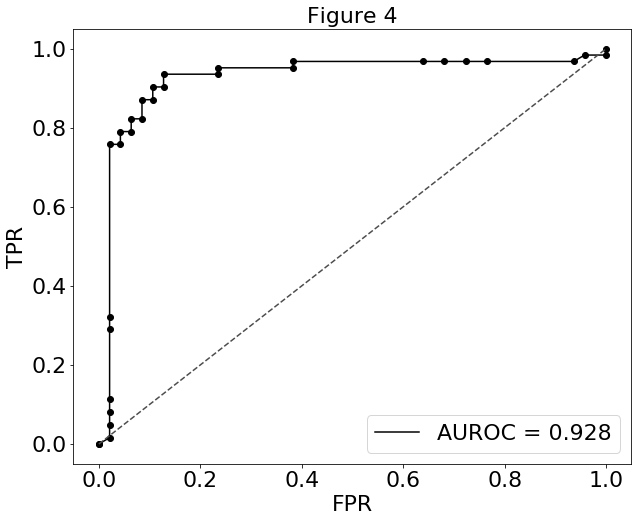

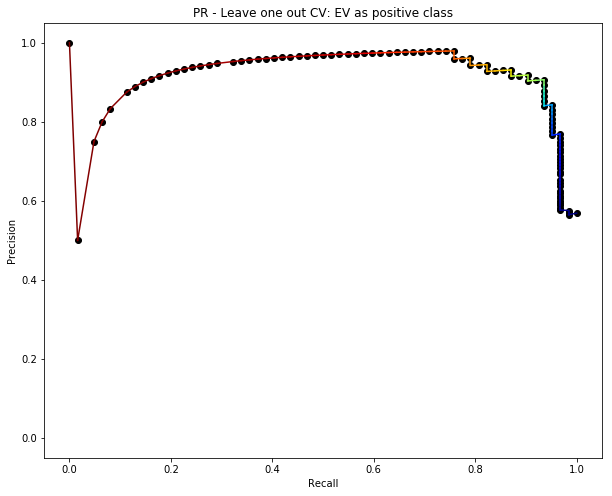

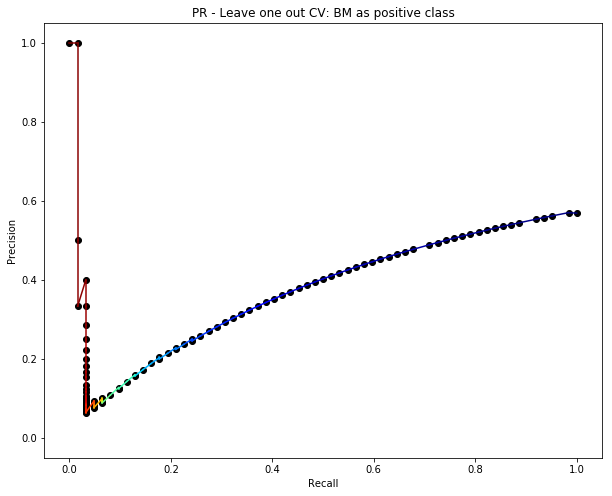

In [8]:
neg_class_labels = ['EVM']

fpr, tpr, thres = roc_curve([0 if x in neg_class_labels else 1 for x in loo_class_label], 
                            loo_pos_class_proba)
fpr = np.insert(fpr, 0, 0)
tpr = np.insert(tpr, 0, 0)

auroc = roc_auc_score([0 if x in neg_class_labels else 1 for x in loo_class_label], loo_pos_class_proba)
print(auroc)
fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
plt.scatter(fpr, tpr, c='k')
plt.title('Figure 4', fontsize=22)
#plot_colourline(fpr, tpr, thres)
plt.plot(fpr, tpr, c='k', label='AUROC = {:.3f}'.format(auroc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
plt.legend(fontsize=22)
plt.xlabel('FPR', fontsize=22)
plt.ylabel('TPR', fontsize=22)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/auc_loo.png'.format(loo_dir), dpi=600)
plt.savefig('../figures/fig4.png'.format(loo_dir), dpi=600)
plt.show()

precision, recall, thres = precision_recall_curve([0 if x in neg_class_labels else 1 for x in loo_class_label],
                                                  loo_pos_class_proba)
plt.subplots(figsize=(10,8))
plt.scatter(recall, precision, c='k')
plt.title('PR - Leave one out CV: EV as positive class')
plot_colourline(recall, precision, thres)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/pr_EV_pos_loo.png'.format(loo_dir), dpi=600)
plt.show()

precision, recall, thres = precision_recall_curve([0 if x in neg_class_labels else 1 for x in loo_class_label],
                                                  [1-x for x in loo_pos_class_proba])
plt.subplots(figsize=(10,8))
plt.scatter(recall, precision, c='k')
plt.title('PR - Leave one out CV: BM as positive class')
plot_colourline(recall, precision, thres)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/pr_BM_pos_loo.png'.format(loo_dir), dpi=600)
plt.show()

# Classifier

In [9]:
class_dir = '{}'.format(maindir)

deg_df = pd.read_csv('{}/plan_EVM_vs_rest/DESeq2_results_EVM2-EVMvsother_fold1_sig.txt'.format(class_dir),
                     sep='\t')
feature_names = deg_df['Unnamed: 0']

class_df = df

train_samples = class_df.index
X_train = class_df.loc[train_samples, feature_names]
Y_train = class_df.loc[train_samples, 'target']


RF = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, class_weight='balanced')
feat_selection = boruta.BorutaPy(ExtraTreesClassifier(n_jobs=-1),
                                 n_estimators='auto',
                                 random_state=0,
                                 alpha=0.001,
                                 two_step=False)
predictor = Pipeline([('feature_selection', feat_selection), ('classification', RF)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %time predictor.fit(X_train.values, Y_train.values)

CPU times: user 1min 31s, sys: 20.8 s, total: 1min 51s
Wall time: 1min 7s


In [10]:
importances = np.zeros(X_train.shape[1], float)
importances[predictor.named_steps['feature_selection'].support_] =\
    predictor.named_steps['classification'].feature_importances_
len(feature_names), len(importances)

selected_features = []
for name, importance in zip(feature_names, importances):
    if importance > 0:
        print(name, importance)
        selected_features.append(name)

gene10009 0.022409112394469462
gene10010 0.006362429750127227
gene10015 0.002641133213744371
gene10276 0.011313452270362382
gene10415 0.022018574698971168
gene13153 0.00951166462570178
gene13154 0.039862860181826214
gene13601 0.02047803329984292
gene15448 0.008675090459992037
gene16190 0.016714234819176242
gene1740 0.006312880654426452
gene1741 0.008520093939413007
gene20761 0.01829081193075495
gene20763 0.020884513626718056
gene24087 0.012536818160341323
gene24865 0.004290520772575115
gene25103 0.0032338930961360347
gene25148 0.00498775683445464
gene26672 0.014367716726963695
gene26702 0.03524824334621752
gene26703 0.007128945623416895
gene26706 0.022510419978284273
gene27022 0.0064599487659930165
gene27726 0.017458099811675842
gene28696 0.021220957793378514
gene28984 0.014911628188826324
gene29231 0.009471782413091054
gene30559 0.016526516946685332
gene3098 0.012264617740851514
gene31448 0.008999449299802701
gene31920 0.011200013080490756
gene31924 0.01756271086830894
gene31955 0.018

In [11]:
gene_dict, unmapped_genes = map_genes(selected_features, key=0, target=3)
print(gene_dict.values())
with open('../data_paper/plan_EVM_vs_rest/predictive_genes_EV-rest.txt', 'w') as o:
    for value in gene_dict.values():
        o.write('{}\n'.format(value))
print(len(gene_dict.keys()))

dict_values(['LOC105374071', 'PARP9', 'PARP14', 'EPHB1', 'PLSCR2', 'DDX60', 'DDX60L', 'LOC389273', 'CCNJL', 'KIAA0319', 'IFI44L', 'IFI44', 'ZC3HAV1', 'TTC26', 'TMEM252', 'MEGF9', 'TOR1B', 'NTNG2', 'LOC105378415', 'IFIT3', 'LOC101926887', 'IFIT1', 'CFAP58', 'TRIM22', 'GIF', 'LOC101927853', 'LOC105369380', 'CLEC1A', 'LOC105371461', 'GLI1', 'LOC102724960', 'TMCC3', 'HAL', 'OAS1', 'OAS3', 'OAS2', 'OASL', 'EPSTI1', 'LOC101928143', 'LOC105371641', 'FAM174B', 'XAF1', 'FBXO39', 'ZCCHC2', 'LOC101927143', 'CACNA1A', 'LOC105372287', 'SIGLEC1', 'ZBP1', 'MX2', 'MX1', 'REPS2', 'ACOT9', 'LOC105373148', 'CMPK2', 'RSAD2', 'EIF2AK2', 'LOC105374771', 'EPHB2', 'SPATS2L', 'CCDC36'])
61


/Users/nicolasdeneuter/miniconda3/envs/gems/lib/python3.6/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':
/Users/nicolasdeneuter/miniconda3/envs/gems/lib/python3.6/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.
/Users/nicolasdeneuter/miniconda3/envs/gems/lib/python3.6/site-packages/ipykernel_launcher.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
/Users/nicolasdeneuter/miniconda3/envs/gems/lib/python3.6/site-packages/ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously lik

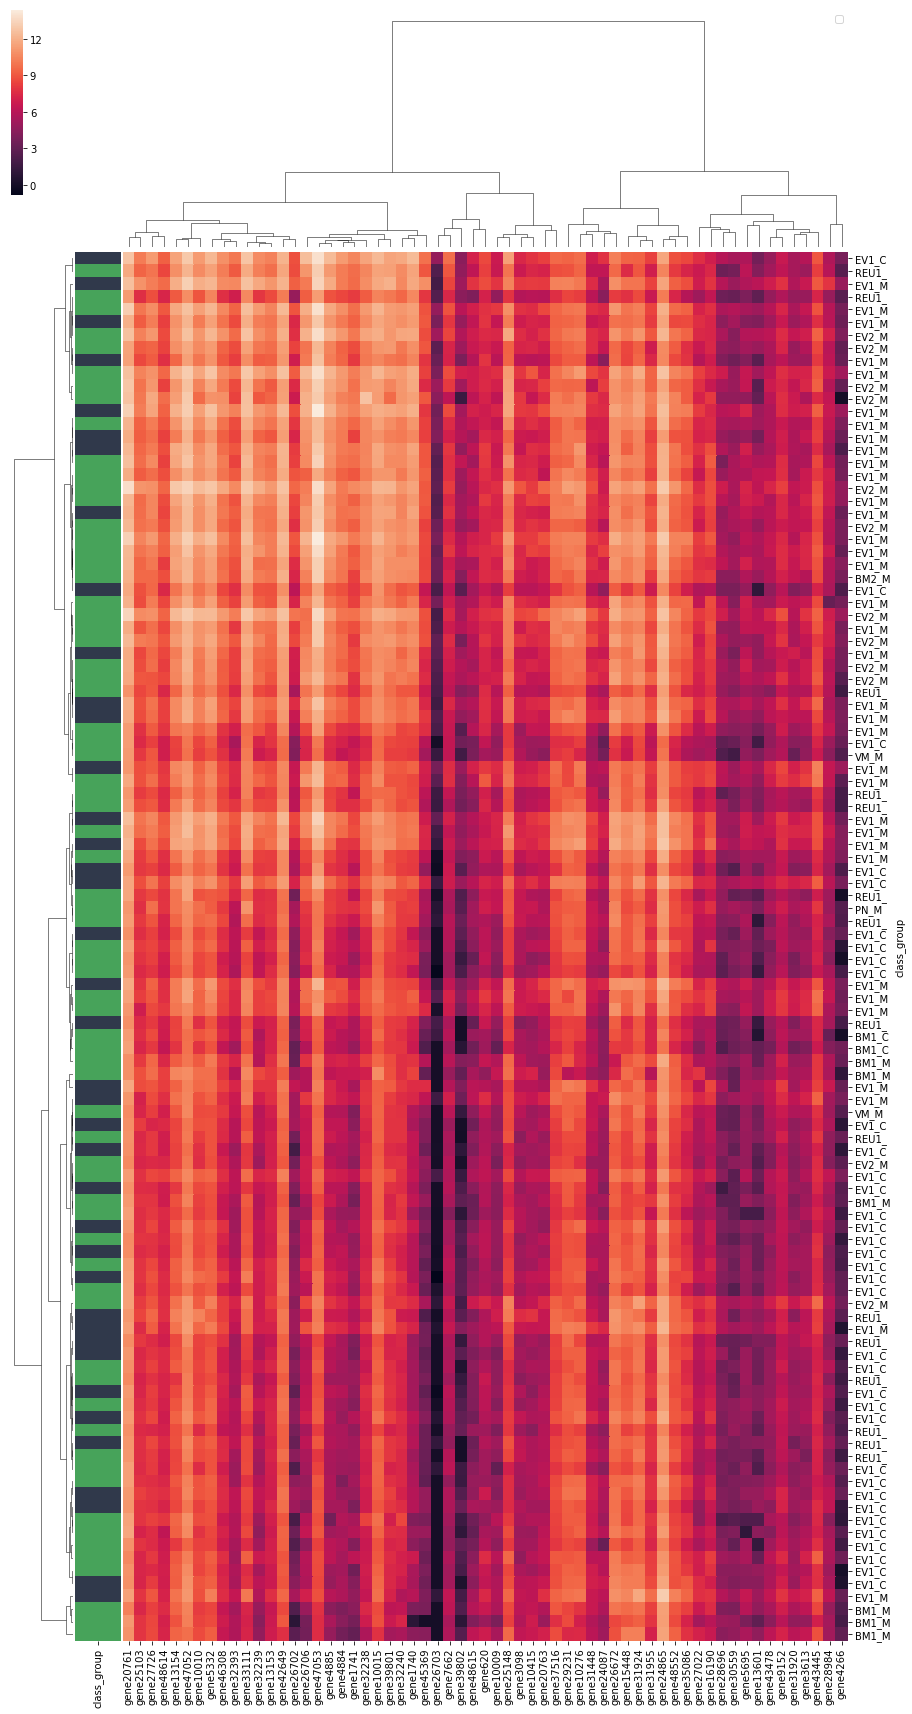

In [12]:
method = 'ward'
distance = 'correlation'

heatmap_df = class_df.loc[:, selected_features].applymap(log)
heatmap_df.index = label_df['class_group']

# cluster rows together
D_rows = squareform(pdist(heatmap_df, distance))
Z_rows = linkage(D_rows, method)
optimal_Z_rows = linkage(D_rows, method, optimal_ordering=True)

# cluster columns together
D_cols = squareform(pdist(heatmap_df.T, distance))
Z_cols = linkage(D_cols, method)
optimal_Z_cols = linkage(D_cols, method, optimal_ordering=True)

# add categorical label to the plot
colors = sns.diverging_palette(255, 133, l=60, n=len(heatmap_df.index.unique()), center="dark")
color_dict = dict(zip(heatmap_df.index.unique(), colors))
row_colors = pd.Series(heatmap_df.index).map(color_dict)
row_colors.index = heatmap_df.index

# with ordering
g = sns.clustermap(heatmap_df, row_linkage=optimal_Z_rows, 
                   col_linkage=optimal_Z_cols, figsize=(15, 30), row_colors=row_colors)
g.ax_col_dendrogram.legend(loc="best", ncol=6)
plt.show()